In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
from dust.plot.maps import map_terrain_china, map_china
from dust.plot.plotting import mpl_base_map_plot_xr,_gen_flexpart_colormap
from thesis_toolbox.plot.tools import add_letter
import matplotlib
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import datetime as dt
import pandas as pd
from matplotlib.lines import Line2D
from dask.distributed import Client, LocalCluster

## Load data

In [2]:
ems_flexdust = xr.open_dataset('../../data/data/results/model_results/intermediate_results/emission_flux.china.MAM.1999-2019.nc')

merra2 = xr.open_mfdataset('../../data/MERRA2/dust/*.nc4',chunks={'time':20},
                       concat_dim=['time'],parallel=True, combine='nested')

In [3]:
ems_merra2 = merra2[[f'DUEM00{i}' for i in range(1,6)]]

## Sum emission

Summing up the emissions from each bin.

In [4]:
total_ems = ems_merra2['DUEM001']

for dvar in ems_merra2.data_vars:
    if dvar == 'DUEM001':
        pass
    else:
        total_ems += ems_merra2[dvar]
    

In [5]:
total_ems.attrs['long_name'] = 'Total dust emission'

spring_ems_merra = total_ems.resample(time='Q-NOV').mean()

spring_ems_merra = spring_ems_merra.where(spring_ems_merra.time.dt.season=='MAM').dropna(dim='time')

In [6]:
spring_ems_merra = spring_ems_merra.compute()

In [7]:
a = dt.datetime(2013,3,1,0,0,0)
b = dt.datetime(2013,5,31,23,59,59)

sec_in_spring = (b-a).total_seconds()
spring_ems_merra = spring_ems_merra*sec_in_spring
spring_ems_merra_avg = spring_ems_merra.mean(dim='time')

area = xr.open_dataset('../../data/gridarea.nc')

spring_ems_merra_avg = spring_ems_merra_avg.sel(lon= slice(55,120), lat=slice(25,55))
spring_ems_merra_avg_mass =spring_ems_merra_avg.sel(lon= slice(55,120), lat=slice(25,55))*area.sel(lon= slice(55,120), lat=slice(25,55))['cell_area']
# 75,115, 30, 50|

In [8]:
ems_flexdust_mean = ems_flexdust.Emission.mean(dim='time')
ems_flexdust_mean_mass = ems_flexdust.Emission.mean(dim='time')*ems_flexdust['area']

In [9]:
def min_max_norm(da):
    return (da-da.min())/(da.max()-da.min())

def derive_source_region_ts(fds, extend_dict, normalize=False):
    data_dict = {}
    for source_region, coords in extend_dict.items():
        temp_region = fds.sel(lon=slice(coords['lon0'],coords['lon1']),lat=slice(coords['lat0'],coords['lat1'])).copy()
        data_dict[source_region] = temp_region.sum(dim=['lon','lat']).values
    data_dict['total'] = fds.sel(lon= slice(55,120), lat=slice(25,55)).sum(dim=['lon','lat']).values
    df = pd.DataFrame(data_dict, index=temp_region.time)
    df['Remainding Sources'] = df['total'] - df[list(source_regions.keys())].sum(axis=1)
    if normalize:
        df = (df - df.min(axis=0))/(df.max(axis=0)-df.min(axis=0))
    return df

In [10]:
flexdust_normed = min_max_norm(ems_flexdust_mean_mass)
merra_normed = min_max_norm(spring_ems_merra_avg_mass)

fds_emissions = ems_flexdust.Emission*ems_flexdust['area']

import yaml
with open("../Master_thesis_UiO_workflow/config/config.yaml", 'r') as f:
    conf = yaml.safe_load(f)
source_regions = conf['source_regions']

In [11]:
ts_fp = derive_source_region_ts(fds_emissions, source_regions, normalize=True)

In [12]:
ts_merra = derive_source_region_ts(spring_ems_merra.dropna(dim='time'), source_regions, normalize=True)
ts_merra.index = [i for i in range(1999,2020)]

In [13]:
ts_fp.index = ts_merra.index

In [14]:
ts_fp = ts_fp.rename(columns={'taklamakan': 'Taklamakan', 'north_west':'Sources North West of CLP','quaidam_basin': 'Quaidam basin',
             'mongolia':'Mongolia', 'jungger_basin':'Gurbantunggut desert', 'central_asia': 'Central Asia', 'total':'Entire domain'})
ts_merra = ts_merra.rename(columns={'taklamakan': 'Taklamakan', 'north_west':'Sources North West of CLP','quaidam_basin': 'Quaidam basin',
             'mongolia':'Mongolia', 'jungger_basin':'Gurbantunggut desert', 'central_asia': 'Central Asia', 'total':'Entire domain'})
colors_d = {'Taklamakan':'tab:blue','Sources North West of CLP': 'tab:green','Quaidam basin':'tab:purple',
            'Mongolia':'tab:orange', 'Gurbantunggut desert':'tab:brown', 'Central Asia':'tab:pink', 'Entire domain':'Black'}

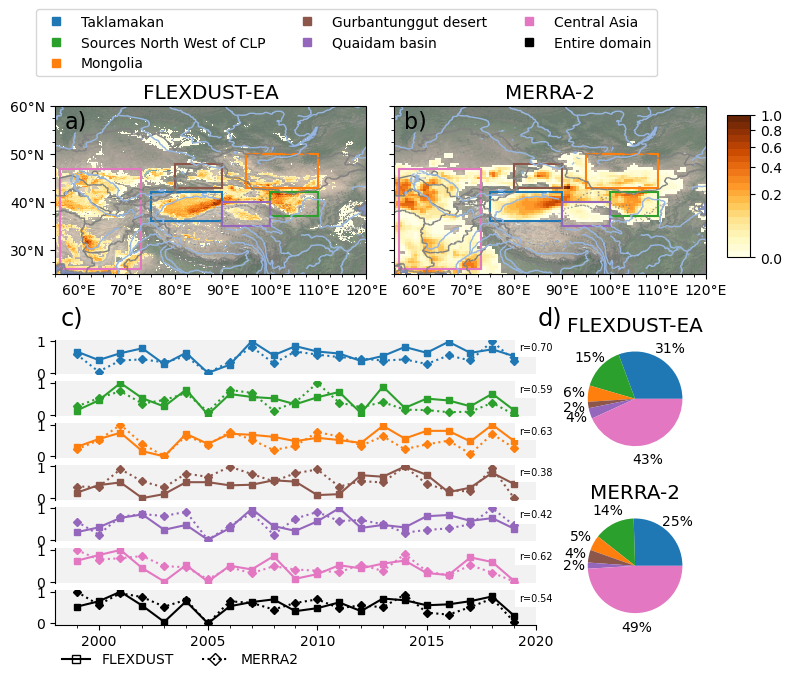

In [19]:
fig = plt.figure(figsize=(8.4,7.5))
# pax=ax[1,:].ravel()

ax = [plt.subplot2grid((14,4),(0,0),rowspan=7,colspan=2, projection=ccrs.PlateCarree()),plt.subplot2grid((14,4),(0,2),rowspan=7,colspan=2, projection=ccrs.PlateCarree())]
cmap = matplotlib.cm.get_cmap('YlOrBr', 21)
map_terrain_china(ax[0])
mpl_base_map_plot_xr(flexdust_normed, ax=ax[0],colorbar=False,vmin=1e-4, vmax=1,add_labels=False,norm=colors.PowerNorm(gamma=0.5), log=False,cmap=cmap)

map_terrain_china(ax[1])
mpl_base_map_plot_xr(merra_normed,ax=ax[1],colorbar=False,vmin=1e-4, vmax=1, add_labels=False, norm=colors.PowerNorm(gamma=0.5),log=False,cmap=cmap)

ax[0].set_extent([55,120, 25, 55])
ax[1].set_extent([55,120, 25, 55])

ax[0].set_title('FLEXDUST-EA')
ax[1].set_title('MERRA-2')
for ax_i in ax:
    ax_i.set_yticks([30, 40, 50, 60], crs=ccrs.PlateCarree())
    ax_i.set_xticks([60,70, 80, 90, 100, 110, 120], crs=ccrs.PlateCarree())
    ax_i.add_patch(Rectangle(xy=[75,36],width=15,height=6, transform=ccrs.PlateCarree(),fill=False,linewidth=1.5, edgecolor='tab:blue'))
    ax_i.add_patch(Rectangle(xy=[100,37],width=10,height=5, transform=ccrs.PlateCarree(),fill=False,linewidth=1.5, edgecolor='tab:green'))
    ax_i.add_patch(Rectangle(xy=[95,43],width=15,height=7, transform=ccrs.PlateCarree(),fill=False,linewidth=1.5, edgecolor='tab:orange'))
    ax_i.add_patch(Rectangle(xy=[80,43],width=10,height=5, transform=ccrs.PlateCarree(),fill=False,linewidth=1.5, edgecolor='tab:brown'))
    ax_i.add_patch(Rectangle(xy=[90,35],width=10,height=5, transform=ccrs.PlateCarree(),fill=False,linewidth=1.5, edgecolor='tab:purple'))
    ax_i.add_patch(Rectangle(xy=[56,26],width=17,height=21, transform=ccrs.PlateCarree(),fill=False,linewidth=1.5, edgecolor='tab:pink'))
ax_i.set_yticklabels([])

add_letter(np.array([ax]),y=0.87)

cax=fig.add_axes([0.925,0.6,0.028,0.19])
cb = fig.colorbar(cm.ScalarMappable(norm=colors.PowerNorm(gamma=0.5), cmap=cmap), cax=cax)

sources = ['Taklamakan', 'Sources North West of CLP', 'Mongolia', 'Gurbantunggut desert',
       'Quaidam basin', 'Central Asia','Entire domain']

colors_d = {'Taklamakan':'tab:blue','Sources North West of CLP': 'tab:green','Quaidam basin':'tab:purple',
            'Mongolia':'tab:orange', 'Gurbantunggut desert':'tab:brown', 'Central Asia':'tab:pink', 'Entire domain':'Black'}

rp =[7,8, 9,10, 11,12, 13]
correlations = ts_merra.corrwith(ts_fp)
for l,col in zip(rp,ts_fp[sources].columns):
    
    ax1 = plt.subplot2grid((14,4),(l,0), colspan=3)
    if l != 13:
        ax1.spines['bottom'].set_visible(False)
        ax1.xaxis.set_tick_params(which='both',bottom=False)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_facecolor('#F2F2F2')
    ts_fp[col].plot(ax=ax1, legend=False,color=colors_d[col],marker='s', markersize=4)
    
    ts_merra[col].plot.line(ax=ax1,legend=False, color=colors_d[col], marker='D', markersize=4, sharex=ax1, sharey=ax1, linestyle=':')
    ax1.text(0.965,0.69,f'r={correlations[col]:.2f}', transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='none', pad=3), size='x-small')
l = []
h = []
for source in sources:
    l.append(source)
    h.append(Line2D([0],[0],marker='s',linestyle='',color=colors_d[source]))
    
ax1.set_xlim(1998,2020)
ax1.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([2000,2005,2010,2015,2020]))
ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
fig.legend(h,l,bbox_to_anchor=(0.85,0.94), ncol=3)
fig.text(0.132, 0.51, 'c)', size='xx-large',transform=fig.transFigure)
h = [Line2D([0],[0],marker='s',color='k', markerfacecolor='none'),
     Line2D([0],[0],marker='D',linestyle=':',color='k', markerfacecolor='none')]

fig.text(0.7, 0.51, 'd)', size='xx-large',transform=fig.transFigure)

ts_fp_no_norm = derive_source_region_ts(fds_emissions, source_regions, normalize=False)

ts_fp_no_norm = ts_fp_no_norm.rename(columns={'taklamakan': 'Taklamakan', 'north_west':'Sources North West of CLP','quaidam_basin': 'Quaidam basin',
             'mongolia':'Mongolia', 'jungger_basin':'Gurbantunggut desert', 'central_asia': 'Central Asia', 'total':'Entire domain'})

ts_fp_no_norm=ts_fp_no_norm[['Taklamakan', 'Sources North West of CLP', 'Mongolia', 'Gurbantunggut desert',
       'Quaidam basin', 'Central Asia']]



ts_merra_no_norm = derive_source_region_ts(spring_ems_merra.dropna(dim='time'), source_regions, normalize=False)
ts_merra_no_norm.index = [i for i in range(1999,2020)]
ts_merra_no_norm = ts_merra_no_norm.rename(columns={'taklamakan': 'Taklamakan', 'north_west':'Sources North West of CLP','quaidam_basin': 'Quaidam basin',
             'mongolia':'Mongolia', 'jungger_basin':'Gurbantunggut desert', 'central_asia': 'Central Asia', 'total':'Entire domain'})
ts_merra_no_norm = ts_merra_no_norm[['Taklamakan', 'Sources North West of CLP', 'Mongolia', 'Gurbantunggut desert',
       'Quaidam basin', 'Central Asia']]


df_fp_no_norm = ts_fp_no_norm.mean(axis=0)
df_color = df_fp_no_norm.index.map(colors_d)
df_fp_no_norm.plot.pie(ax=plt.subplot2grid((14,4),(7,3), rowspan=3), colors=df_color,pctdistance=1.3, autopct='%1.0f%%',label='',labeldistance=None, title=
                      'FLEXDUST-EA')

df_merra_no_norm = ts_merra_no_norm.mean(axis=0)
df_color = df_merra_no_norm.index.map(colors_d)


df_merra_no_norm.plot.pie(ax=plt.subplot2grid((14,4),(11,3), rowspan=3,), colors=df_color,pctdistance=1.3, autopct='%1.0f%%',label='',labeldistance=None
                         ,title='MERRA-2')

fig.legend(h,['FLEXDUST', 'MERRA2' ],bbox_to_anchor=(0.43,0.09),frameon=False, ncol=2)
# plt.subplots_adjust(hspace=)


plt.savefig('Emission_comparison_flexdust_merra.png',bbox_inches='tight', dpi=300)